## Dataset Creation for Cellvit Head Training 

Using our data and their pipeline


In [1]:
import os
os.getcwd()

'/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedData_npy_new_dir/ProcessedData_npy'

### Step 1: Create Images and Labels folders

We currently have images in png and labels in np format. We want to create csv files with just center coordinates for the classifier head.


In [6]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import random

# === CONFIG ===

images_dir = "images"
labels_dir = "labels_np"
splits_dir = "splits"
seed = 19
val_ratio = 0.2  # 20% validation

# Ensure splits folder exists
os.makedirs(splits_dir, exist_ok=True)

# === COLLECT FILENAMES ===
# assuming filenames are like train_1.png and train_1.npy
image_files = [f for f in os.listdir(images_dir) if f.endswith((".png", ".jpg", ".jpeg"))]
image_basenames = [os.path.splitext(f)[0] for f in image_files]

# match only those that have a label counterpart
paired_files = [f for f in image_basenames if os.path.exists(os.path.join(labels_dir, f + ".npy"))]
print(f"Found {len(paired_files)} paired image/label samples.")

# === SPLIT ===
train_ids, val_ids = train_test_split(
    paired_files,
    test_size=val_ratio,
    random_state=seed,
    shuffle=True
)

# === SAVE CSVs ===
train_csv = os.path.join(splits_dir, "train.csv")
val_csv = os.path.join(splits_dir, "val.csv")

pd.DataFrame(train_ids, columns=["id"]).to_csv(train_csv, index=False)
pd.DataFrame(val_ids, columns=["id"]).to_csv(val_csv, index=False)

print(f"Saved {len(train_ids)} train and {len(val_ids)} val samples.")
print(f"Train CSV: {train_csv}")
print(f"Val CSV:   {val_csv}")


Found 200 paired image/label samples.
Saved 160 train and 40 val samples.
Train CSV: splits/train.csv
Val CSV:   splits/val.csv


In [3]:
import os, numpy as np, pprint

labels_dir = "labels_np"
label_files = [f for f in os.listdir(labels_dir) if f.endswith(".npy")]
assert label_files, "No .npy files found in labels_dir"

def inspect_label_file(path):
    try:
        # Try numeric arrays
        arr = np.load(path)
        print(f"[NUMPY ARRAY] {os.path.basename(path)}")
        print("  shape:", arr.shape, "dtype:", arr.dtype)
        if np.issubdtype(arr.dtype, np.integer) or np.issubdtype(arr.dtype, np.bool_):
            uniques = np.unique(arr)
            print("  unique values:", uniques[:50], "(truncated if many)")
        print()
        return arr
    except ValueError as e:
        if "allow_pickle=False" in str(e):
            print(f"[OBJECT ARRAY] {os.path.basename(path)} -> loading with allow_pickle=True")
            obj = np.load(path, allow_pickle=True)
            if obj.shape == () and obj.dtype == object:
                obj = obj.item()
            print("  type:", type(obj))
            if isinstance(obj, dict):
                print("  dict keys:", list(obj.keys()))
                # show a small preview for common keys
                for k in list(obj.keys())[:5]:
                    v = obj[k]
                    if isinstance(v, np.ndarray):
                        print(f"   - {k}: ndarray shape={v.shape}, dtype={v.dtype}")
                    else:
                        print(f"   - {k}: {type(v)} -> {str(v)[:120]}")
            elif isinstance(obj, (list, tuple)):
                print("  list/tuple length:", len(obj))
                if obj:
                    print("  first item type:", type(obj[0]))
                    print("  first item preview:", str(obj[0])[:200])
            else:
                print("  preview:", str(obj)[:200])
            print()
            return obj
        else:
            raise

sample_path = os.path.join(labels_dir, label_files[0])
print("Inspecting:", sample_path)
_ = inspect_label_file(sample_path)


Inspecting: labels_np/TCGA-EJ-5517-01Z-00-DX1-3_0_0.npy
[OBJECT ARRAY] TCGA-EJ-5517-01Z-00-DX1-3_0_0.npy -> loading with allow_pickle=True
  type: <class 'dict'>
  dict keys: ['type_map']
   - type_map: ndarray shape=(512, 512), dtype=int32



In [4]:
sample = np.load("labels_np/TCGA-EJ-5517-01Z-00-DX1-3_0_0.npy", allow_pickle=True).item()
print(sample.keys())
arr = sample["type_map"]
print("shape:", arr.shape, "dtype:", arr.dtype)
print("unique values:", np.unique(arr))


dict_keys(['type_map'])
shape: (512, 512) dtype: int32
unique values: [0 4]


Sample: TCGA-55-1594-01Z-00-DX1_001_0_0.npy
Unique class IDs: [0 1 2]
Found 61 cells.


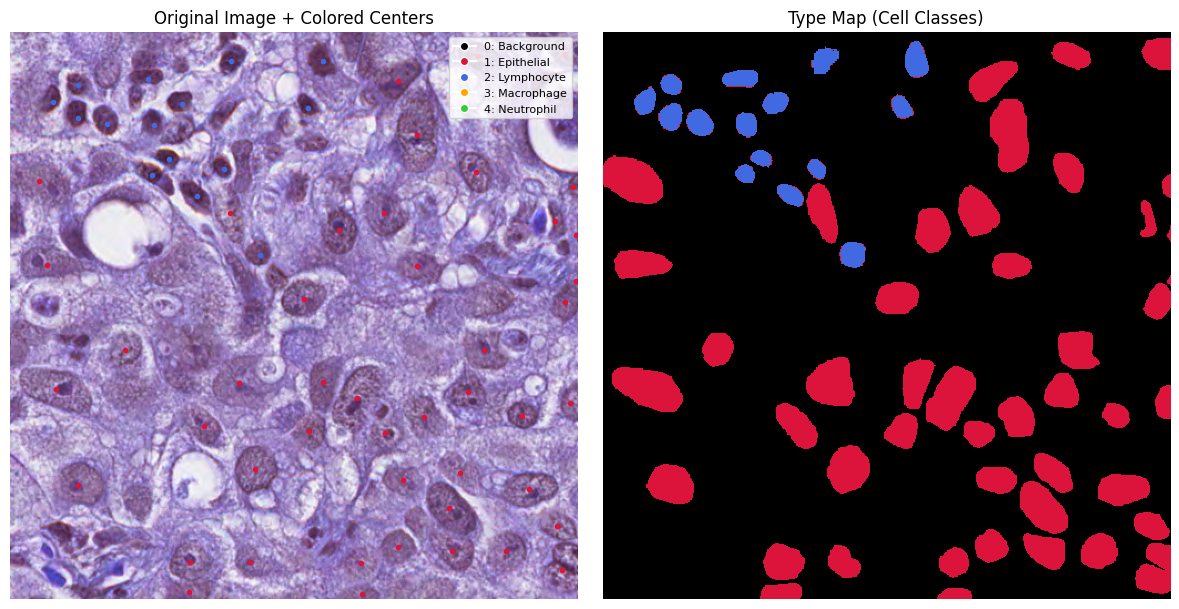

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import regionprops, label as cc_label
from collections import Counter
import imageio.v3 as iio
from matplotlib.colors import ListedColormap

# ---- Paths ----
images_dir = "images"
labels_dir = "labels_np"

# pick one sample
sample_name = sorted([f for f in os.listdir(labels_dir) if f.endswith(".npy")])[0]
print("Sample:", sample_name)

label_path = os.path.join(labels_dir, sample_name)
image_path = os.path.join(images_dir, sample_name.replace(".npy", ".png"))

# ---- Load ----
label_data = np.load(label_path, allow_pickle=True).item()
type_map = label_data["type_map"]
inst_map = label_data.get("inst_map")
if inst_map is None:
    inst_map = cc_label(type_map > 0)

print("Unique class IDs:", np.unique(type_map))

# ---- Extract centers & classes ----
centers = []
for region in regionprops(inst_map):
    y, x = region.centroid
    pixels = type_map[inst_map == region.label]
    if pixels.size > 0:
        cls = Counter(pixels.tolist()).most_common(1)[0][0]
        centers.append((x, y, cls))
centers = np.array(centers)
print(f"Found {len(centers)} cells.")

# ---- Visualization ----
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
img = iio.imread(image_path)

# Colormap and legend
class_colors = {
    0: "black",      # Background
    1: "crimson",    # Epithelial
    2: "royalblue",  # Lymphocyte
    3: "orange",     # Macrophage
    4: "limegreen",  # Neutrophil
}
cmap = ListedColormap([class_colors[i] for i in sorted(class_colors.keys())])

# Left: original image + centers
axs[0].imshow(img)
axs[0].set_title("Original Image + Colored Centers")
axs[0].axis("off")

# Right: segmentation map
axs[1].imshow(type_map, cmap=cmap, vmin=0, vmax=4)
axs[1].set_title("Type Map (Cell Classes)")
axs[1].axis("off")

# Overlay color-coded centers
for (x, y, c) in centers:
    color = class_colors.get(int(c), "white")
    axs[0].plot(x, y, "o", markersize=3, color=color)
    axs[1].plot(x, y, "o", markersize=3, color=color)

# Legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                              label=f"{cid}: {name}",
                              markerfacecolor=color, markersize=6)
                   for cid, (name, color) in enumerate([
                       ("Background", "black"),
                       ("Epithelial", "crimson"),
                       ("Lymphocyte", "royalblue"),
                       ("Macrophage", "orange"),
                       ("Neutrophil", "limegreen")
                   ])]
axs[0].legend(handles=legend_elements, loc="upper right", fontsize=8)

plt.tight_layout()
plt.show()


### Creating csv using the detected centers

In [17]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from skimage.measure import regionprops

# === CONFIG ===
images_dir = "images"        # folder with *.png (or jpg/jpeg) images
labels_dir = "labels_np"        # folder with *.npy dicts: {"inst_map": HxW, "type_map": HxW}
out_dir    = "labels"    # where we'll write one CSV per image: x,y,class
os.makedirs(out_dir, exist_ok=True)

# === COLLECT FILENAMES ===
# pair images to labels by basename (e.g., TCGA-... .png <-> .npy)
image_files = [f for f in os.listdir(images_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
image_basenames = [os.path.splitext(f)[0] for f in image_files]
paired = [b for b in image_basenames if os.path.exists(os.path.join(labels_dir, b + ".npy"))]

print(f"Found {len(paired)} paired image/label samples.")

# === HELPER: extract (x, y, class) from inst_map + type_map ===
def inst_to_centers_and_classes(inst_map: np.ndarray, type_map: np.ndarray):
    rows = []
    for region in regionprops(inst_map):
        # skimage returns (row, col) = (y, x)
        y, x = region.centroid
        # majority vote class within the instance
        cls_vals = type_map[inst_map == region.label]
        if cls_vals.size == 0:
            continue
        cls = Counter(cls_vals.tolist()).most_common(1)[0][0]
        rows.append((int(x), int(y), int(cls)))  # (x, y, class) as required
    return rows

# === PROCESS EACH SAMPLE ===
empty_count = 0
for base in sorted(paired):
    npy_path = os.path.join(labels_dir, base + ".npy")
    try:
        lab = np.load(npy_path, allow_pickle=True)
        if getattr(lab, "shape", ()) == () and getattr(lab, "dtype", None) == object:
            lab = lab.item()
        inst_map = lab["inst_map"]
        type_map = lab["type_map"]
    except Exception as e:
        print(f"⚠️ Skipping {base}: failed to load/parse labels ({e})")
        continue

    centers = inst_to_centers_and_classes(inst_map, type_map)

    if not centers:
        empty_count += 1
        print(f"No cells found in {base}.npy")
        continue

    # save WITHOUT header
    csv_path = os.path.join(out_dir, base + ".csv")
    pd.DataFrame(centers).to_csv(csv_path, index=False, header=False)
    # Print short confirmation
    print(f"Saved {len(centers):4d} cells → {csv_path}")

print("\n Done!")
if empty_count:
    print(f"Note: {empty_count} files had no instances.")
print(f"Output folder: {os.path.abspath(out_dir)}")


Found 200 paired image/label samples.
⚠️ Skipping TCGA-55-1594-01Z-00-DX1_001_0_0: failed to load/parse labels ('inst_map')
⚠️ Skipping TCGA-55-1594-01Z-00-DX1_001_0_512: failed to load/parse labels ('inst_map')
⚠️ Skipping TCGA-55-1594-01Z-00-DX1_001_512_0: failed to load/parse labels ('inst_map')
⚠️ Skipping TCGA-55-1594-01Z-00-DX1_001_512_512: failed to load/parse labels ('inst_map')
⚠️ Skipping TCGA-55-1594-01Z-00-DX1_002_0_0: failed to load/parse labels ('inst_map')
⚠️ Skipping TCGA-55-1594-01Z-00-DX1_003_0_0: failed to load/parse labels ('inst_map')
⚠️ Skipping TCGA-55-1594-01Z-00-DX1_004_0_0: failed to load/parse labels ('inst_map')
⚠️ Skipping TCGA-55-1594-01Z-00-DX1_005_0_0: failed to load/parse labels ('inst_map')
⚠️ Skipping TCGA-5P-A9K0-01Z-00-DX1_1_0_0: failed to load/parse labels ('inst_map')
⚠️ Skipping TCGA-5P-A9K0-01Z-00-DX1_1_0_512: failed to load/parse labels ('inst_map')
⚠️ Skipping TCGA-5P-A9K0-01Z-00-DX1_1_512_0: failed to load/parse labels ('inst_map')
⚠️ Skippin

In [9]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from skimage.measure import regionprops

# === CONFIG ===
images_dir = "train/images"        # folder with *.png (or jpg/jpeg) images
labels_dir = "labels_np"        # folder with *.npy dicts: {"inst_map": HxW, "type_map": HxW}
out_dir    = "train/labels"    # where we'll write one CSV per image: x,y,class
os.makedirs(out_dir, exist_ok=True)

# === COLLECT FILENAMES ===
image_files = [f for f in os.listdir(images_dir)
               if f.lower().endswith((".png", ".jpg", ".jpeg"))]
image_basenames = [os.path.splitext(f)[0] for f in image_files]
paired = [b for b in image_basenames
          if os.path.exists(os.path.join(labels_dir, b + ".npy"))]

print(f"Found {len(paired)} paired image/label samples.")

# --- Remap helper: map raw class ids to 0..3 (drop others) ---
def remap(cls):
    # common cases: classes stored as 1..4; background/ignore as 0, 255, -1
    if 1 <= cls <= 4:
        return cls - 1
    else:
        return None  # drop anything outside 1..4

# === HELPER: extract (x, y, class) from inst_map + type_map ===
def inst_to_centers_and_classes(inst_map: np.ndarray, type_map: np.ndarray):
    rows = []
    for region in regionprops(inst_map):
        # skimage centroid = (row=y, col=x)
        y, x = region.centroid
        # classes in this instance
        cls_vals = type_map[inst_map == region.label].ravel()
        if cls_vals.size == 0:
            continue
        # majority vote
        raw_cls = Counter(cls_vals.tolist()).most_common(1)[0][0]
        mapped = remap(int(raw_cls))
        if mapped is None:
            continue
        rows.append((int(x), int(y), mapped))  # (x, y, class in 0..3)
    return rows

# === PROCESS EACH SAMPLE ===
empty_count = 0
saved_count = 0
dropped_count = 0

for base in sorted(paired):
    npy_path = os.path.join(labels_dir, base + ".npy")
    try:
        lab = np.load(npy_path, allow_pickle=True)
        if getattr(lab, "shape", ()) == () and getattr(lab, "dtype", None) == object:
            lab = lab.item()
        inst_map = lab["inst_map"]
        type_map = lab["type_map"]
    except Exception as e:
        print(f"⚠️ Skipping {base}: failed to load/parse labels ({e})")
        continue

    centers = inst_to_centers_and_classes(inst_map, type_map)

    if not centers:
        empty_count += 1
        # optional: skip writing an empty CSV (recommended)
        # If you prefer an empty file, uncomment the next 3 lines:
        # csv_path = os.path.join(out_dir, base + ".csv")
        # open(csv_path, "w").close()
        # print(f"Wrote empty CSV for {base}")
        print(f"No valid cells for {base} (after remap).")
        continue

    # save WITHOUT header
    csv_path = os.path.join(out_dir, base + ".csv")
    pd.DataFrame(centers).to_csv(csv_path, index=False, header=False)
    saved_count += 1
    if any(c not in (0,1,2,3) for *_, c in centers):
        dropped_count += 1  # defensive; should not trigger
    if saved_count % 50 == 0:
        print(f"Saved {saved_count:4d} CSVs so far...")

print("\nDone!")
print(f"Saved CSVs: {saved_count}")
print(f"Tiles with no valid cells (empty after remap): {empty_count}")
print(f"Output folder: {os.path.abspath(out_dir)}")


Found 201 paired image/label samples.
Saved   50 CSVs so far...
No valid cells for TCGA-D8-A1X5-01Z-00-DX2_4_512_0 (after remap).
Saved  100 CSVs so far...
Saved  150 CSVs so far...
Saved  200 CSVs so far...

Done!
Saved CSVs: 200
Tiles with no valid cells (empty after remap): 1
Output folder: /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedData_npy/train/labels


In [10]:
# --- CONFIG: set your dataset root ---
ROOT = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedData_npy"

import os, glob, pandas as pd, numpy as np
from pathlib import Path

def stems_from_split(split_csv):
    stems = []
    with open(split_csv, "r") as f:
        for line in f:
            s = line.strip()
            if s:
                stems.append(s)
    return set(stems)

def collect_labels(split):
    # paths
    img_dir = Path(ROOT) / split / "images"
    lab_dir = Path(ROOT) / split / "labels"
    split_file = Path(ROOT) / "splits" / f"{'train' if split=='train' else 'val'}.csv"
    use_stems = stems_from_split(split_file) if split_file.exists() else None

    rows = []
    # list stems that actually have image+label file
    # (extensions: png/jpg/jpeg)
    image_stems = {Path(p).stem for ext in ("*.png","*.jpg","*.jpeg")
                   for p in glob.glob(str(img_dir / ext))}
    label_stems = {Path(p).stem for p in glob.glob(str(lab_dir / "*.csv"))}

    # intersection + optional split filter
    cand = image_stems & label_stems
    if use_stems is not None:
        cand = cand & use_stems

    for stem in sorted(cand):
        csv_path = lab_dir / f"{stem}.csv"
        try:
            # read fast without header; 3 columns expected
            df = pd.read_csv(csv_path, header=None, names=["x","y","label"])
        except Exception as e:
            rows.append({"split": split, "stem": stem, "valid": False, "reason": f"read_error: {e}"})
            continue

        # drop fully empty lines
        df = df.dropna(how="any")
        # coerce to int (invalids become NaN then dropped)
        for c in ["x","y","label"]:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        df = df.dropna().astype({"x": int, "y": int, "label": int})

        if df.empty:
            rows.append({"split": split, "stem": stem, "valid": False, "reason": "empty_after_clean"})
            continue

        # summarize
        vc = df["label"].value_counts().sort_index()
        min_lab, max_lab = int(df["label"].min()), int(df["label"].max())
        out_of_range = df.loc[(df["label"] < 0) | (df["label"] > 3), "label"].tolist()

        rows.append({
            "split": split,
            "stem": stem,
            "valid": True,
            "n_rows": len(df),
            "min_label": min_lab,
            "max_label": max_lab,
            "counts": vc.to_dict(),
            "oor_samples": out_of_range[:5],  # preview up to 5 offending labels
            "oor_count": len(out_of_range),
        })

    return pd.DataFrame(rows)

train_df = collect_labels("train")
val_df   = collect_labels("val")
summary  = pd.concat([train_df, val_df], ignore_index=True)

# Expand per-class counts to columns (0..3), fill missing with 0
for c in [0,1,2,3]:
    summary[f"count_{c}"] = summary["counts"].apply(lambda d: int(d.get(c, 0)) if isinstance(d, dict) else 0)

# Display a sortable table of per-image counts
summary_display = summary.drop(columns=["counts"])
summary_display.sort_values(["split","stem"], inplace=True)
summary_display.reset_index(drop=True, inplace=True)
summary_display


,split,stem,valid,n_rows,min_label,max_label,oor_samples,oor_count,count_0,count_1,count_2,count_3
0,train,TCGA-55-1594-01Z-00-DX1_001_0_0,True,62,0,1,[],0,47,15,0,0
1,train,TCGA-55-1594-01Z-00-DX1_001_0_512,True,72,0,1,[],0,67,5,0,0
2,train,TCGA-55-1594-01Z-00-DX1_001_512_0,True,82,0,0,[],0,82,0,0,0
3,train,TCGA-55-1594-01Z-00-DX1_002_0_0,True,300,1,1,[],0,0,300,0,0
4,train,TCGA-55-1594-01Z-00-DX1_003_0_0,True,36,1,2,[],0,0,12,24,0
...,...,...,...,...,...,...,...,...,...,...,...,...
154,train,TCGA-V1-A8WL-01Z-00-DX1-1_0_0,True,92,0,1,[],0,89,3,0,0
155,train,TCGA-V1-A9O9-01Z-00-DX1-1_0_0,True,144,0,1,[],0,2,142,0,0
156,train,TCGA-V1-A9O9-01Z-00-DX1-2_0_0,True,259,0,1,[],0,5,254,0,0
157,train,TCGA-YL-A9WY-01Z-00-DX1-1_512_0,True,40,0,0,[],0,40,0,0,0


In [11]:
summary.describe

<bound method NDFrame.describe of      split                               stem  valid  n_rows  min_label  \
0    train    TCGA-55-1594-01Z-00-DX1_001_0_0   True      62          0   
1    train  TCGA-55-1594-01Z-00-DX1_001_0_512   True      72          0   
2    train  TCGA-55-1594-01Z-00-DX1_001_512_0   True      82          0   
3    train    TCGA-55-1594-01Z-00-DX1_002_0_0   True     300          1   
4    train    TCGA-55-1594-01Z-00-DX1_003_0_0   True      36          1   
..     ...                                ...    ...     ...        ...   
154  train      TCGA-V1-A8WL-01Z-00-DX1-1_0_0   True      92          0   
155  train      TCGA-V1-A9O9-01Z-00-DX1-1_0_0   True     144          0   
156  train      TCGA-V1-A9O9-01Z-00-DX1-2_0_0   True     259          0   
157  train    TCGA-YL-A9WY-01Z-00-DX1-1_512_0   True      40          0   
158  train  TCGA-YL-A9WY-01Z-00-DX1-1_512_512   True      44          0   

     max_label          counts oor_samples  oor_count  count_0  c

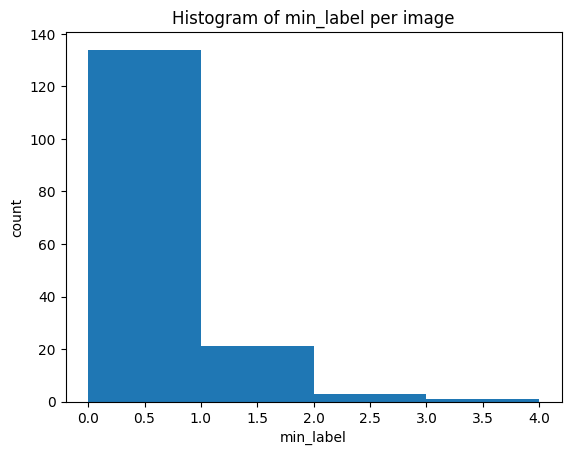

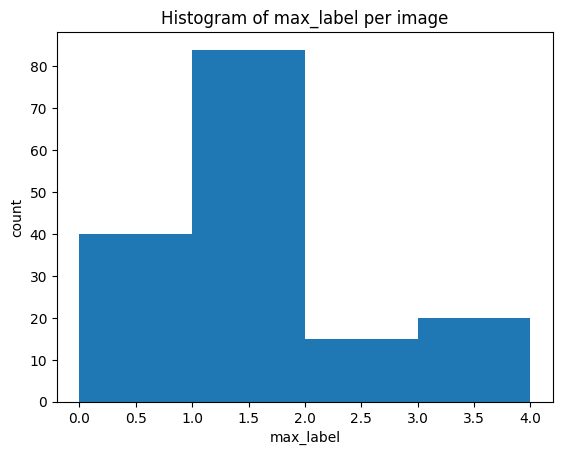

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# grab your dataframe (works if you used my earlier cells)
df = summary
if df is None:
    raise RuntimeError("Expected a DataFrame named `summary` or `summary_display` in memory.")

# ensure numeric
for col in ("min_label", "max_label"):
    df[col] = pd.to_numeric(df[col], errors="coerce")

min_vals = df["min_label"].dropna().astype(int)
max_vals = df["max_label"].dropna().astype(int)

# histogram of min_label
plt.figure()
plt.hist(min_vals, bins=range(int(min_vals.min()), int(min_vals.max())+2))
plt.title("Histogram of min_label per image")
plt.xlabel("min_label")
plt.ylabel("count")
plt.show()

# histogram of max_label
plt.figure()
plt.hist(max_vals, bins=range(int(max_vals.min()), int(max_vals.max())+2))
plt.title("Histogram of max_label per image")
plt.xlabel("max_label")
plt.ylabel("count")
plt.show()


In [21]:
summary[summary.min_label==2]

,split,stem,valid,n_rows,min_label,max_label,counts,oor_samples,oor_count,count_0,count_1,count_2,count_3
68,train,TCGA-BH-A18T-01Z-00-DX1_2_0_0,True,13,2,2,{2: 13},[],0,0,0,13,0
113,train,TCGA-G9-6499-01Z-00-DX1-1_0_0,True,24,2,2,{2: 24},[],0,0,0,24,0
114,train,TCGA-G9-6499-01Z-00-DX1-1_512_0,True,14,2,2,{2: 14},[],0,0,0,14,0
